# Jupyter Notebook per Abilità Informatiche
Progetto Covid-19, regione Puglia
Periodo: 25 gennaio - 12 febbraio

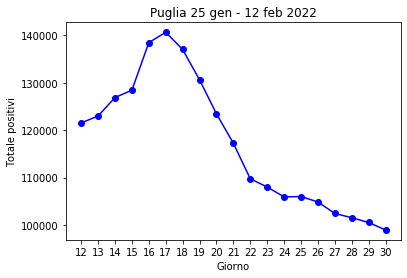

In [22]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy

x = []
y = []

#leggo i dati 
for line in open('daticovid.txt', 'r'):
    lines = [i for i in line.split()]
    x.append(lines[0])
    y.append(int(lines[1]))
    
#plot totale dei positivi nel periodo considerato
plt.title("Puglia 25 gen - 12 feb 2022")
plt.xlabel('Giorno')
plt.ylabel('Totale positivi')
plt.plot(x, y, marker = 'o', c = 'b')
  
plt.show()

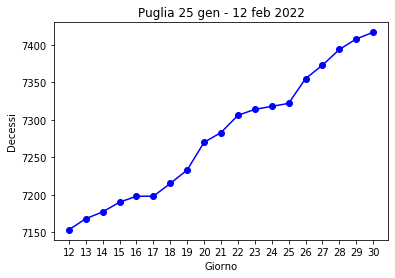

In [23]:
x=[]
y=[]

#leggo i dati 
for line in open('decessi.txt', 'r'):
    lines = [i for i in line.split()]
    x.append(lines[0])
    y.append(int(lines[1]))
    
#plot totale dei positivi nel periodo considerato
plt.title("Puglia 25 gen - 12 feb 2022")
plt.xlabel('Giorno')
plt.ylabel('Decessi')
plt.plot(x, y, marker = 'o', c = 'b')
  
plt.show()

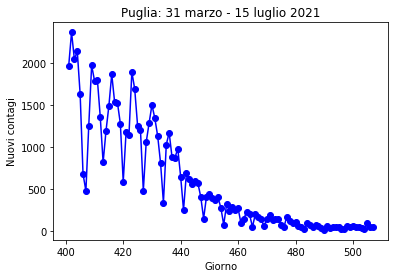

In [24]:
x=[]
y=[]

#leggo i dati 
for line in open('test.txt', 'r'):
    lines = [i for i in line.split()]
    x.append(int(lines[1]))
    y.append(int(lines[0]))


#plot totale dei positivi sull'intero dataset
plt.title("Puglia: 31 marzo - 15 luglio 2021")
plt.xlabel('Giorno')
plt.ylabel('Nuovi contagi')
plt.plot(x, y, marker = 'o', c = 'b')
  
plt.show()

In [38]:
#definisco la funzione che calcola la log-likelihood negativa
def likelihood(t):
    l=0
    a=[None]*np.size(y)
    #print(a)
    for i in range(0,np.size(a)):
        a[i]=math.log(math.factorial(y[i]))
    #print(a)
    l=-np.sum(a)+math.log(t)*np.sum(y)
    #print(l)
    return -(l-np.size(y)*t)

In [55]:
res = scipy.optimize.minimize_scalar(likelihood, method='bounded', bounds=(1, 10000))
print(res)

     fun: 35531.31940299074
 message: 'Solution found.'
    nfev: 15
  status: 0
 success: True
       x: 588.3083988525714
